# <font color=#025dfa> Flipkart Duygu Analizini - Flipkart Sentiment Analysis

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, Flipkart'ta kullanıcılar tarafından bırakılan yorum ve incelemelerin duygusal tonlarını otomatik olarak analiz etmeyi amaçlayan bir modelin geliştirilmesini hedeflemektedir. Kullanıcıların ürünlerle ilgili geri bildirimlerini analiz ederek, yorumların pozitif, negatif veya nötr duygusal içerik taşıyıp taşımadığını belirlemek için doğal dil işleme teknikleri kullanılacaktır.

EN = This project aims to develop a model that aims to automatically analyze the emotional tones of comments and reviews left by users on Flipkart. By analyzing user feedback on products, natural language processing techniques will be used to determine whether the comments carry positive, negative or neutral emotional content.

Kaynak/Source = https://thecleverprogrammer.com/2022/02/15/flipkart-reviews-sentiment-analysis-using-python/

In [1]:
#pip install pycaret

In [2]:
#pip install textblob

In [3]:
#pip install langdetect

In [4]:
#pip install googletrans==4.0.0-rc1

In [5]:
#pip install autocorrect

In [6]:
#pip install neattext

In [7]:
import pandas as pd
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings('ignore')
import re
import time
import datetime
import matplotlib.pyplot as plt
import neattext.functions as nfx
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from autocorrect import spell
from textblob import TextBlob
from langdetect import detect
from googletrans import Translator
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pycaret.classification import *
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
pd.set_option("display.max_columns",None)
# TR = En fazla kaç sütun olduğunu gösteriyor.
# EN = It shows the maximum number of columns.

In [9]:
df=pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/flipkart_reviews.csv")

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis

In [10]:
df.head()

,Product_name,Review,Rating
0,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Best under 60k Great performanceI got it for a...,5
1,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Good perfomence...,5
2,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Great performance but usually it has also that...,5
3,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,My wife is so happy and best product 👌🏻😘,5
4,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,"Light weight laptop with new amazing features,...",5


In [11]:
df.sample(5)

,Product_name,Review,Rating
2073,SAMSUNG 7.2 kg with Double Storm Technology Se...,It's really nice washing machine and it has gr...,4
1133,"Redmi 9A Sport (Coral Green, 32 GB) (3 GB RAM)",Phone working is Very Good,5
1272,"Xiaomi 11i 5G (Camo Green, 128 GB) (8 GB RAM)","11i 8gb version: Battery: Lasts all day, even ...",4
816,LG 80 cm (32 inch) HD Ready LED Smart TV (32L...,Really it's value for money. Picture quality i...,5
170,"realme C25Y (Metal Grey, 128 GB) (4 GB RAM)",Poor camera quality Infact same time not worki...,1


In [12]:
df.tail()

,Product_name,Review,Rating
2299,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,"Great display, accurate colours at this price ...",5
2300,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Superb monitor first brought 1 used for 2 mont...,5
2301,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Awesome,5
2302,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Only one issue with adapter,5
2303,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Worth the money u spend for this monitor Great...,5


In [13]:
df.shape

(2304, 3)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_name  2304 non-null   object
 1   Review        2304 non-null   object
 2   Rating        2304 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 54.1+ KB


In [15]:
df.isnull().sum().sort_values(ascending=False)

Product_name    0
Review          0
Rating          0
dtype: int64

## <font color='#ff4d00'> Boşluk Varsa Doldurmaya, Düzeltilecek Kısım Varsa Düzeltmeye Başladık - If there is a gap, we started to fill it and if there is a part to be corrected, we started to correct it.

In [16]:
df['Review'][0]

'Best under 60k Great performanceI got it for around 58500Battery backup is bit low but thanks to rapid charger its very fast Display is Ok for this price range Decent speakers with many customisation optionsVantage software is so good for customisationOverall good performance till nowWill update later if any problem occurs'

In [17]:
df['Review'][1]

'Good perfomence...'

In [18]:
df['Review'][2]

"Great performance but usually it has also that gaming laptop's issue of battery. It can only stand for 2 - 3 hrs without adapter. So, I prefer that use it with adaptor if you are using any software or playing games."

In [19]:
def algo_text(df):

  for col in df.columns:
    if df[col].dtype=='object':
      df[col] = df[col].str.lower()
      df[col] = df[col].str.replace('[^\w\s]', '', regex=True)
      df[col] = df[col].str.replace('\n', '',regex=True)
      df[col] = df[col].str.replace('\d+', '',regex=True)
      df[col] = df[col].str.replace('\r', '',regex=True)
      df[col] = df[col].str.replace('.', '',regex=True)
      df[col] = df[col].str.replace(',', '',regex=True)
    return df
    # TR = Bu kod data type object olan verilerin buluyor ve onlarda istenmeyen işartetleri kaldırıyor.
    # EN = This code finds the data with data type object and removes the unwanted marks from them.

df=algo_text(df)

In [20]:
df['Review'][2]

"Great performance but usually it has also that gaming laptop's issue of battery. It can only stand for 2 - 3 hrs without adapter. So, I prefer that use it with adaptor if you are using any software or playing games."

In [21]:
def detect_veri(reviewText):
    try:
        return detect(reviewText)
    except:
        return 'unknown'
    # TR = Text sütunundaki verilerin hangi dillerde yazıldığını tespit etme.
    # EN = Detecting in which languages ​​the data in the text column is written.

start_time = time.time()
# TR = start_time adında bir değişken tanımla, time.time() kodu ile şimdiki zamanı al.
# EN = Define a variable called start_time and get the current time with the time.time() code.

df['language'] = df['Review'].apply(detect_veri)
# TR = language diye yeni bir sütün oluşturma. Oluşan yeni sütunu text bulunduğu sütunun .apply(detect_veri) kodu ile hangi dilde yazıldığını bul.
# EN = Creating a new column called language. Find the language in which the new column contains text, using the .apply(detect_veri) code.

end_time = time.time()
# TR = end_time adında bir değişken tanımla, time.time() kodu ile şimdiki zamanı al.
# EN = Define a variable called end_time and get the current time with the time.time() code.

elapsed_time = end_time - start_time
# TR = Dil tespitin ne kadar sürdüğünü bulmak için end_time'dan start_time'mı çıkar.
# EN = Subtract start_time from end_time to find how long language detection took.
print(f"{elapsed_time} saniye")

7.827089786529541 saniye


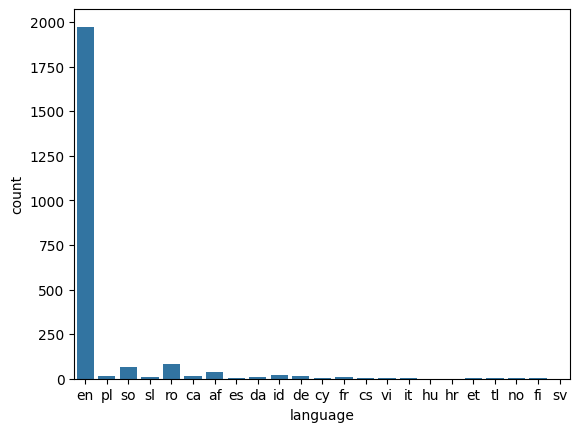

In [22]:
sns.countplot(x=df['language']);

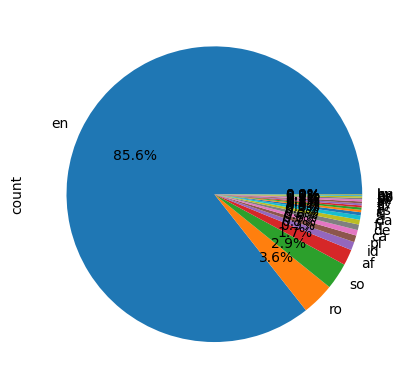

In [23]:
df['language'].value_counts().plot.pie(autopct='%1.1f%%');

In [24]:
df=df[df['language']=='en']
# TR = language sütünündaki veriler en kelimesine eşitmi
# EN =

df.drop(index= df[df['language']!='en'].index, inplace=True)
# TR = language sütünündaki en kelimesine eşit olmayan satırları sil.
# EN = Delete rows in the language column that do not equal the word en.

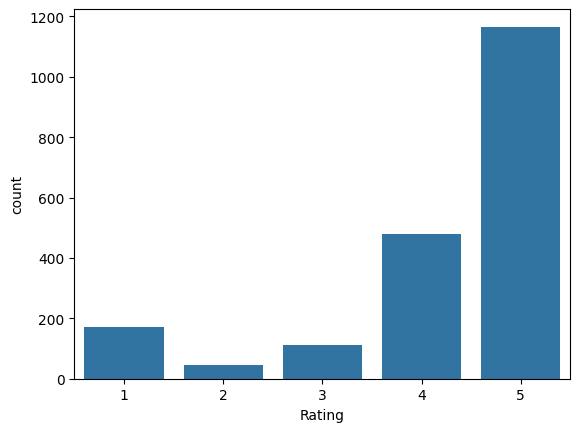

In [25]:
sns.countplot(x=df['Rating']);

## <font color='#0ceb31'>Duygu Analizi - Sentiment Analysis

### <font color=#06c750>Yorumların Olumlumu ya da Olumsuzmu Olduğunu Tespit Etme - Determining Whether Comments Have Death or Immortality

In [26]:
df['sentiment']=df['Rating']
df['sentiment']=df['sentiment'].replace([5,4],'olumlu')
df['sentiment']=df['sentiment'].replace([1,2],'olumsuz')
df['sentiment']=df['sentiment'].replace([3],'notr')
# TR = sentiment diye yeni bir sütun oluşturup () sütünundaki verilere eşitledik. [5,4],'olumlu', [1,2],'olumsuz', [3],'notr'
# EN = We created a new column called sentiment and set it equal to the data in the () column. [5,4],'positive', [1,2],'negative', [3],'neutral'

In [27]:
df=df[['Rating','Review','sentiment']]# a yerine puan ya da yıldız gibi değerini belirten sayı, b yerine yazımızın bulunduğu sütün adı

In [28]:
df=df[(df['sentiment']=='olumlu')|(df['sentiment']=='notr')|(df['sentiment']=='olumsuz')]
# TR = sentimentimizi olumlu ya da olumsuz ya da notr olacak şekilde tanımladık.
# EN = We defined our sentiment as positive, negative or neutral.

In [29]:
df.reset_index(drop=True,inplace=True)
# TR = Yukarıda yaptığımız işlem neticesinde olumlu,notr,olumsuz kelimeler kendi içlerinde üst üste oldular. Bu yüzden indexlerini sıfırlayıp tekrar verdik.
# EN = As a result of the process we did above, positive, neutral and negative words were placed on top of each other. That's why we reset their indexes and gave them again.

In [30]:
x = df['Review']
y = df['sentiment']

In [31]:
yelpbw = df[(df.Rating == 1) | (df.Rating == 2) | (df.Rating == 3) | (df.Rating == 4) | (df.Rating == 5)]

In [32]:
yelpbw.reset_index(drop=True,inplace=True)

In [33]:
vect=CountVectorizer(stop_words='english',ngram_range=(1,2))

In [34]:
x=yelpbw["Review"]
y=yelpbw["Rating"]

In [35]:
vect=CountVectorizer()
x=vect.fit_transform(x)

In [36]:
def lemmafn(Review):
    words=TextBlob.words
    return [pr.stem(word) for word in words]

## <font color=#10e6e6> En çok Sayıdaki Kelimeleri Kap İçine Alma - Containing the Most Numbered Words

In [37]:
#wc=wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    # TR = Kabımızın boyutunu belirttik.
    # EN = We specified the size of our container.

    mask=np.array(Image.open('cloud.png'))
    # TR = Image.open ile resmimizi açtık. np.array resmi diziye çevirdik ve mask değişkenine atadık.
    # EN = We opened our image with Image.open. We converted the np.array image to an array and assigned it to the mask variable.

    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask)
    # TR = Bir WordCloud tanımladık. Arka plan rengini bgcolor eşitledik. stopwords=STOPWORDS ile gereksiz kelimeleri atıp anahtar kelimeleri sakladık.
    # EN = We defined a WordCloud. We set the background color equal to bgcolor. We removed unnecessary words and kept keywords with stopwords=STOPWORDS

    # TR = mask=mask yukarıda tanımladığımız mask değişkenini kullan.
    # EN = mask=mask use the mask variable we defined above.
    wc.generate(''.join(data))
    # TR = .join(data) ile bütün sütündaki text alıp birleştirecek.
    # EN = With .join(data) it will take the text in all columns and combine them.

    # TR = İçinde geçen tüm kelimeleri sayacak ve hafızada tutup generate ile tanımladığımız WordCloud oluşturduk ona eşitleyecek.
    # EN = It will count all the words in it, keep it in memory and synchronize it with the WordCloud we created with generate.

    plt.imshow(wc)
    plt.axis('off')
    # TR = Bunla kod ile x ve y gözükmüyor.
    # EN = With this code, x and y do not appear.

In [38]:
olumlu = df[(df['Rating'] == 5) | (df['Rating'] == 4)]['Review']
nötr = df[df['Rating'] == 3]['Review']
olumsuz = df[(df['Rating'] == 1) | (df['Rating'] == 2)]['Review']
# TR = 4 ya da 5 rating olanları olumlu, 3 rating olan nötr ve 1 ya da 2 rating olanları olumsuz değişkenine eşitledik.
# EN = We equated those with 4 or 5 rating to positive, those with 3 rating to neutral, and those with 1 or 2 rating to negative.

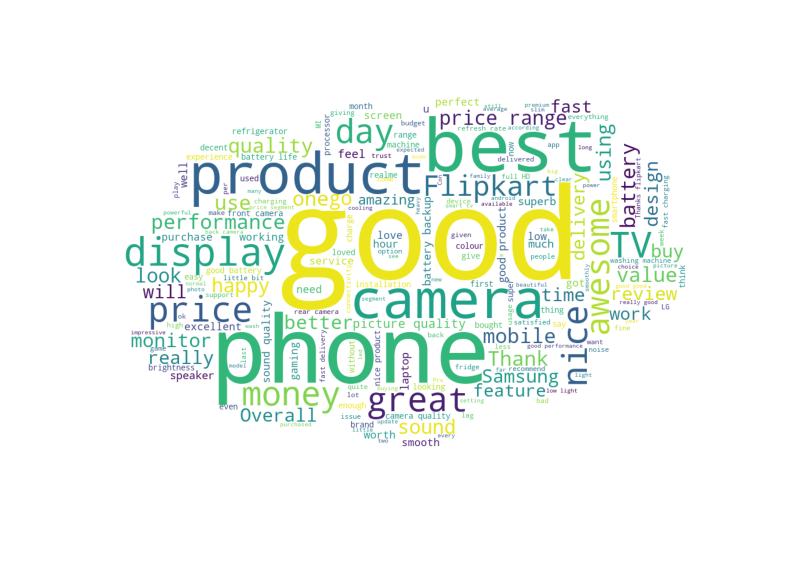

In [39]:
wc(olumlu,'white')

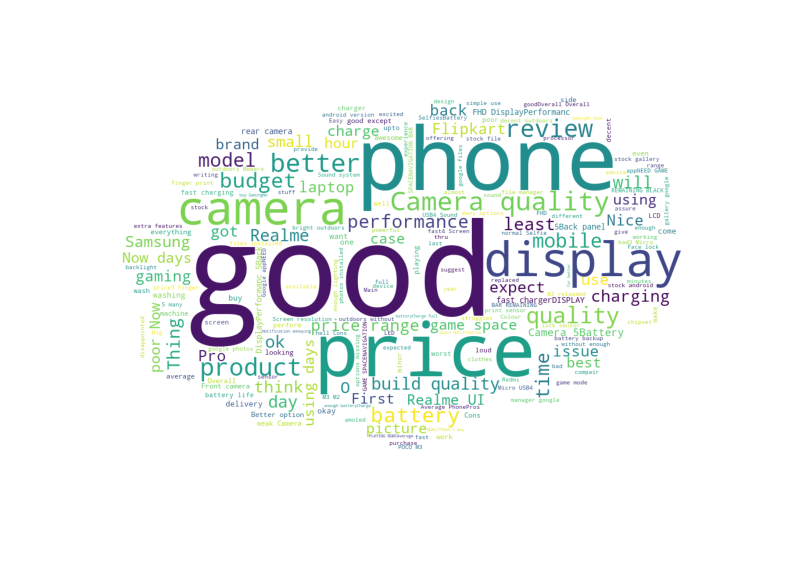

In [40]:
wc(nötr,'white')

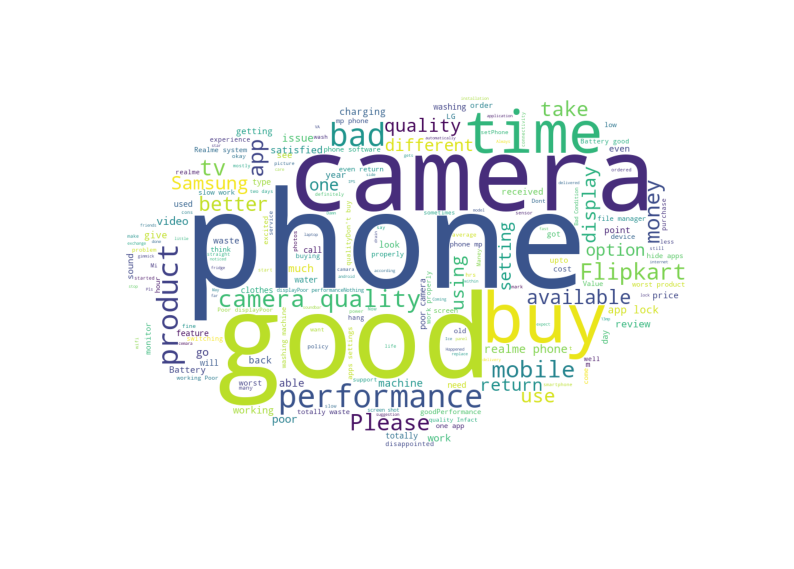

In [41]:
wc(olumsuz,'white')

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling

In [42]:
x = df['Review'].fillna('')  # Fill NaN values with an empty string

# Target variable (ratings)
y = df['Rating'].apply(lambda rating: 1 if rating >= 4 else 0)  # 1: Positive, 0: Negative

In [43]:
vectorizer = TfidfVectorizer(max_features=1000)
x = vectorizer.fit_transform(x).toarray()

In [44]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik.
# EN = We trained our model.

In [45]:
model=Sequential()
model.add(Dense(64, activation='relu', input_shape=(x.shape[1],)))
# TR = Bu katman, tüm giriş nöronlarına bağlantı kurar ve her nöronun ağırlıklarını öğrenir. 64 nöron var.
# Aktivasyon fonksiyonunu ReLU (Rectified Linear Unit) olarak ayarlar. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürür ve pozitif değerleri olduğu gibi bırakır.
# EN = This layer connects all input neurons and learns the weights of each neuron. There are 64 neurons.
# Sets the activation function to ReLU (Rectified Linear Unit). The ReLU function converts negative values ​​to zero and leaves positive values ​​as is.

model.add(Dropout(0.2))
# TR = Derin öğrenme modelinde aşırı uyumu (overfitting) azaltmak için kullanılır.
# EN = It is used to reduce overfitting in the deep learning model.

model.add(Dense(1, activation='sigmoid'))
# TR = Çıkış katmanına 1 nöron ve sigmoid aktivasyon fonksiyonu ekliyoruz.
# EN = We add an output layer with 1 neurons and a sigmoid activation function.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# TR = Modeli binary_crossentropy kayıp fonksiyonu, Adam optimizasyonu ve doğruluk metriği ile derliyoruz.
# EN = We compile the model with binary_crossentropy loss function, Adam optimizer, and accuracy metric.

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

history=model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
# TR = Modeli eğitir ve early stopping callback'ini kullanır.
# EN = Trains the model with early stopping callback.

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8223 - loss: 0.6081 - val_accuracy: 0.8532 - val_loss: 0.4140
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8360 - loss: 0.3909 - val_accuracy: 0.8532 - val_loss: 0.3520
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8087 - loss: 0.3661 - val_accuracy: 0.8633 - val_loss: 0.3140
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8475 - loss: 0.2968 - val_accuracy: 0.8861 - val_loss: 0.2759
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.2036 - val_accuracy: 0.9114 - val_loss: 0.2431
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9510 - loss: 0.1753 - val_accuracy: 0.9114 - val_loss: 0.2263
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9608 - loss: 0.1358 - val_accuracy: 0.9291 - val_loss: 0.2082
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9765 - loss: 0.1142 - val_accuracy: 0.9291 - v

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,389 (751.52 KB)

 Trainable params: 64,129 (250.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 128,260 (501.02 KB)

In [47]:
test_loss, test_acc = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test doğruluğu: {test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.9352 - loss: 0.1734
Test doğruluğu: 0.9367


In [48]:
pred=model.predict(x_test)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik.
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [49]:
pred = (pred > 0.5).astype(int).flatten()

In [50]:
accuracy_score(y_test, pred)
# TR = accuracy_score fonksiyonu ile y_test, pred kullanarak sonucumuzu bulduk.
# EN = We found our result using the accuracy_score function and y_test, pred.

0.9367088607594937

In [51]:
confusion_matrix(y_test, pred)
# TR = confusion_matrix fonksiyonu ile y_test, pred kullanarak ne kadarını yanlış tahmin ettiğimizi buluyoruz
# EN = Using the confusion_matrix function and y_test, pred, we find out how much we guessed wrong.

# TR = 4 sayı değeri veriyor bize. Sol üst ve sağ alt doğru tahmin, sağ üst ve sol alt yanlış tahmin.
# EN = It gives us 4 number values. Upper left and lower right are correct guesses, upper right and lower left are incorrect guesses.

array([[ 36,  22],
       [  3, 334]], dtype=int64)

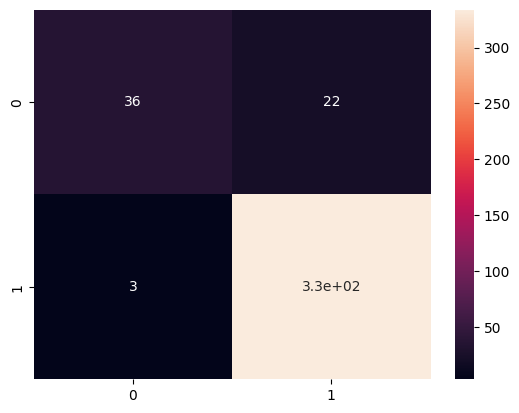

In [52]:
sns.heatmap(confusion_matrix(y_test, pred),annot=True);
# TR = Yukarıdakinin görsel versiyonu.
# EN = Visual version of the above.

In [53]:
print(classification_report(y_test, pred))
# TR = print içinde yazdık yoksa sayıların sıralanması bozuluyor.
# EN = We wrote it in print, otherwise the order of the numbers will be disrupted.

# TR = classification_report ile y_test, pred kullanarak precision, recall, f1-score ve support ulaştık.
# EN = We achieved precision, recall, f1-score and support using classification_report and y_test, pred.

# TR = Precision (Kesinlik): Doğru olarak pozitif tahmin edilen örneklerin, toplam pozitif tahmin edilen örnekler içindeki oranını gösterir. Yani, modelin pozitif sınıfı ne kadar doğru tahmin ettiğini ölçer.
# EN = Precision (Precision): It shows the ratio of correctly predicted positive samples among the total positive predicted samples. That is, it measures how accurately the model predicts the positive class.

# TR = Recall (Duyarlılık): Gerçek pozitif örneklerin, toplam pozitif örnekler içindeki oranını gösterir. Modelin pozitif sınıfı ne kadar iyi bulduğunu ölçer.
# EN = Recall (Sensitivity): Shows the ratio of true positive samples in total positive samples. It measures how well the model finds the positive class.

# TR = F1-score: Precision ve recall'un harmonik ortalamasıdır. Hem precision hem de recall'u dikkate alarak modelin genel performansını özetler.
# EN = F1-score: It is the harmonic mean of precision and recall. It summarizes the overall performance of the model, taking into account both precision and recall.

# TR = Support: Her sınıftan kaç örneğin bulunduğunu gösterir. Yani, gerçek etiketlerde her bir sınıfa ait kaç örnek olduğunu ifade eder.
# EN = Support: Shows how many examples of each class are available. That is, it expresses how many examples of each class there are in the real labels.

              precision    recall  f1-score   support

           0       0.92      0.62      0.74        58
           1       0.94      0.99      0.96       337

    accuracy                           0.94       395
   macro avg       0.93      0.81      0.85       395
weighted avg       0.94      0.94      0.93       395



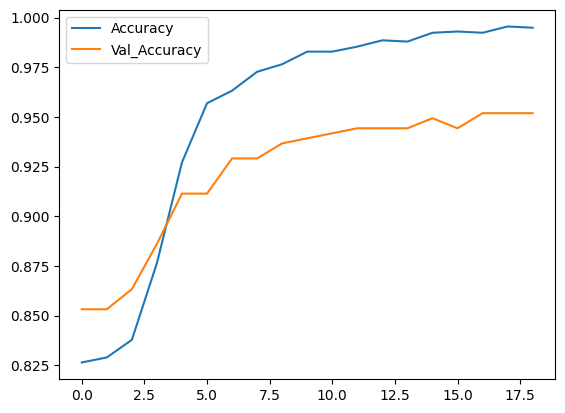

In [54]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend();

## <font color='#ec11f7'> Transfer Learning

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df=pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/flipkart_reviews.csv")

x = df['Review'].fillna('')  # Fill NaN values with an empty string

# Target variable (ratings)
y = df['Rating'].apply(lambda rating: 1 if rating >= 4 else 0)  # 1: Positive, 0: Negative

# Metin verilerini TF-IDF ile dönüştür
vectorizer = TfidfVectorizer(max_features=1000)
x = vectorizer.fit_transform(x).toarray()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# TR = Veriyi eğitim ve test setlerine böler.
# EN = Splits the data into training and test sets.

model = Sequential()
# TR = Sıralı model oluşturur.
# EN = Creates a Sequential model.

model.add(Dense(64, input_shape=(x_train.shape[1],), activation='relu'))
# TR = Giriş katmanını ekler, 64 nöronlu ve ReLU aktivasyon fonksiyonlu.
# EN = Adds the input layer with 64 neurons and ReLU activation function.

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
# TR = Çıkış katmanına 1 nöron ve sigmoid aktivasyon fonksiyonu ekliyoruz.
# EN = We add an output layer with 1 neurons and a sigmoid activation function.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# TR = Modeli binary_crossentropy kayıp fonksiyonu, Adam optimizasyonu ve doğruluk metriği ile derliyoruz.
# EN = We compile the model with binary_crossentropy loss function, Adam optimizer, and accuracy metric.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# TR = Early stopping callback'i tanımlar, val_loss izlenir, gelişme olmazsa 5 epoch sonra durdurur.
# EN = Defines the early stopping callback, monitors val_loss, stops after 5 epochs without improvement.

model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
# TR = Modeli eğitir ve early stopping callback'ini kullanır.
# EN = Trains the model with early stopping callback.

loss, accuracy = model.evaluate(x_test, y_test)
# TR = Modelin performansını test verisinde değerlendirir.
# EN = Evaluates the model's performance on test data.

print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

pred = model.predict(x_test)
pred = (pred > 0.5).astype(int).flatten()

acc=accuracy_score(y_test, pred)
cm=confusion_matrix(y_test, pred)
cr=classification_report(y_test, pred)
print('Accuracy Score:', acc)
print('confusion_matrix:', cm)
print('classification_report:', cr)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7426 - loss: 0.6268 - val_accuracy: 0.8547 - val_loss: 0.4230
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8292 - loss: 0.4270 - val_accuracy: 0.8568 - val_loss: 0.3382
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8352 - loss: 0.3569 - val_accuracy: 0.8915 - val_loss: 0.2868
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8691 - loss: 0.3004 - val_accuracy: 0.9067 - val_loss: 0.2402
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9147 - loss: 0.2379 - val_accuracy: 0.9393 - val_loss: 0.2105
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9473 - loss: 0.1936 - val_accuracy: 0.9458 - val_loss: 0.1932
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9576 - loss: 0.1650 - val_accuracy: 0.9436 - val_loss: 0.1826
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9625 - loss: 0.1404 - val_accuracy: 0.9479 - v

## <font color='orange'> AUTOML

In [56]:
setup(df,target='Rating')

NameError: name 'setup' is not defined

In [ ]:
best_model=compare_models()

In [ ]:
best_model=create_model('lr')

In [ ]:
plot_model(best_model,plot='feature')